In [2]:
# Libraries
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import csv

import requests
import os, json, time, random, datetime as dt

import praw
from prawcore.exceptions import RequestException, ResponseException, ServerError, Forbidden, TooManyRequests

## Sentiment Analysis

In [1]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/diegozapataalcaraz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
import re
from nltk.sentiment import SentimentIntensityAnalyzer

# === Config ===
COMMENTS_CSV = "afl_comments.csv"
TEAM = "North Melbourne"  

# Map teams to common nicknames/hashtags for matching
TEAM_ALIASES = {
    "Adelaide": ["adelaide", "crows"],
    "Brisbane": ["brisbane", "lions", "bne"],
    "Carlton": ["carlton", "blues"],
    "Collingwood": ["collingwood", "pies", "magpies"],
    "Essendon": ["essendon", "bombers", "dons"],
    "Fremantle": ["fremantle", "dockers", "freo"],
    "Geelong": ["geelong", "cats"],
    "Gold Coast": ["gold coast", "suns", "gc"],
    "GWS": ["gws", "giants", "greater western sydney"],
    "Hawthorn": ["hawthorn", "hawks"],
    "Melbourne": ["melbourne", "demons", "dees"],
    "North Melbourne": ["north melbourne", "kangaroos", "roos", "north"],
    "Port Adelaide": ["port adelaide", "power", "port"],
    "Richmond": ["richmond", "tigers", "tigs"],
    "St Kilda": ["st kilda", "saints"],
    "Sydney": ["sydney", "swans", "bloods"],
    "West Coast": ["west coast", "eagles", "wce"],
    "Western Bulldogs": ["western bulldogs", "bulldogs", "dogs", "doggies"],
}

# Build a regex to detect mentions of the target team (word boundaries; case-insensitive)
aliases = TEAM_ALIASES.get(TEAM, [TEAM])
pat = r"\b(" + "|".join(re.escape(a) for a in aliases) + r")\b"
team_re = re.compile(pat, flags=re.IGNORECASE)

# === Load comments ===
df = pd.read_csv(COMMENTS_CSV, dtype={"id": str})
df["body"] = df["body"].fillna("")

# Filter to comments that mention the team (you can skip this to score all then group)
df = df[df["body"].str.contains(team_re, na=False)]

# === VADER sentiment ===
sia = SentimentIntensityAnalyzer()

# AFL slang tweaks
sia.lexicon.update({
    "robbed": -2.0, "bottled": -1.6, "choked": -1.8, "clutch": 1.6,
    "gun": 1.2, "soft": -0.8, "dog act": -2.0, "howler": -1.5,
    "ump": -0.6, "umpiring": -0.8, "set shot": 0.3, "clanger": -1.2,
    "killer": 1.1, "cunt": -1
})

def score(txt: str) -> float:
    return sia.polarity_scores(txt)["compound"] 

df["sent"] = df["body"].astype(str).map(score)

# Simple labels
def label(x):
    if x >= 0.05: return "pos"
    if x <= -0.05: return "neg"
    return "neu"

df["label"] = df["sent"].map(label)

# Preprocessing
n = len(df)
mean_sent = df["sent"].mean() if n else 0.0
pct_pos = (df["label"].eq("pos").mean()*100) if n else 0.0
pct_neg = (df["label"].eq("neg").mean()*100) if n else 0.0

print(f"Team: {TEAM}")
print(f"Comments mentioning team: {n:,}")
print(f"Mean sentiment (compound): {mean_sent:.3f}")
print(f"% positive: {pct_pos:.1f}%   % negative: {pct_neg:.1f}%")

# Top phrases, frequent bigrams in neg/pos buckets)
from collections import Counter
def bigrams(s):
    toks = re.findall(r"[a-zA-Z']+", s.lower())
    return zip(toks, toks[1:])

top_neg = Counter(b for text in df.loc[df["label"]=="neg","body"] for b in bigrams(text)).most_common(10)
top_pos = Counter(b for text in df.loc[df["label"]=="pos","body"] for b in bigrams(text)).most_common(10)

print("\nTop negative bigrams:")
for (w1,w2), c in top_neg[:10]:
    print(f"  {w1} {w2}  ({c})")

print("\nTop positive bigrams:")
for (w1,w2), c in top_pos[:10]:
    print(f"  {w1} {w2}  ({c})")

# (Optional) Save scored comments for this team
df_out = df[["id","submission_id","created_datetime_utc","author","score","body","sent","label"]]
df_out.to_csv(f"sent_{TEAM.replace(' ','_').lower()}.csv", index=False)
print(f"\nSaved per-comment scores → sent_{TEAM.replace(' ','_').lower()}.csv")


Team: North Melbourne
Comments mentioning team: 223
Mean sentiment (compound): 0.255
% positive: 59.6%   % negative: 25.6%

Top negative bigrams:
  in the  (17)
  it was  (10)
  north melbourne  (10)
  the last  (8)
  to the  (6)
  was a  (6)
  west coast  (6)
  of their  (6)
  and north  (5)
  after the  (5)

Top positive bigrams:
  in the  (40)
  of the  (33)
  north melbourne  (28)
  as a  (23)
  to the  (19)
  on the  (18)
  in a  (17)
  would be  (15)
  the afl  (15)
  a good  (14)

Saved per-comment scores → sent_north_melbourne.csv


/var/folders/6h/7_s8d7dn5p565dythb22sn0c0000gn/T/ipykernel_2757/209095370.py:40: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[df["body"].str.contains(team_re, na=False)]


## Merge

In [14]:
afl_results_2025 = pd.read_csv("afl_results_2025.csv")
afl_results_2025 = afl_results_2025.sort_values(by="date_utc")
afl_results_2025["date_utc"] = pd.to_datetime(afl_results_2025.date_utc, utc=True)
afl_results_2025.shape

(213, 17)

In [ ]:
#Getting data
afl_comments1 = pd.read_csv("afl_comments.csv")
afl_comments2 = pd.read_csv("afl_comments2.csv")
afl_comments = pd.concat([afl_comments1, afl_comments2], axis=0, ignore_index=True)
afl_comments = afl_comments.drop_duplicates(subset=['id'], keep='first')

In [19]:
# Preprocessing
afl_comments["created_datetime_utc"] = pd.to_datetime(afl_comments.created_datetime_utc, utc=True)
afl_comments = afl_comments.sort_values(by="created_datetime_utc")
afl_comments.head()

,id,link_id,parent_id,submission_id,author,score,created_utc,created_datetime_utc,body
31513,ncoivy5,t3_1n9qaah,t3_1n9qaah,1n9qaah,Pleasant_Inspection9,7,1.757133e+09,2025-09-06 04:24:19+00:00,https://preview.redd.it/c5yqngni1hnf1.png?widt...
31460,ncokryd,t3_1n9qet4,t3_1n9qet4,1n9qet4,legally_blond,27,1.757134e+09,2025-09-06 04:38:52+00:00,>But if the broadcasters don’t want to do it t...
31462,ncokynm,t3_1n9qet4,t3_1n9qet4,1n9qet4,No-Rise2743,11,1.757134e+09,2025-09-06 04:40:21+00:00,I like the pre finals bye. Gets all the best p...
31469,ncol994,t3_1n9qet4,t3_1n9qet4,1n9qet4,lazy-bruce,0,1.757134e+09,2025-09-06 04:42:40+00:00,I like the idea of 1 bye.\n\nBut I also like t...
31459,ncolg7q,t3_1n9qet4,t3_1n9qet4,1n9qet4,Tall-Breakfast-6100,43,1.757134e+09,2025-09-06 04:44:12+00:00,I’m all for one week bye round. Just makes so ...


In [20]:
afl_merge = pd.merge_asof(afl_comments, afl_results_2025, left_on="created_datetime_utc", right_on="date_utc", direction="backward")
afl_merge.head()

,id,link_id,parent_id,submission_id,author,score,created_utc,created_datetime_utc,body,season,...,home_behinds,home_score,away_goals,away_behinds,away_score,winner_team,margin,is_final,is_grand_final,game_id
0,ncoivy5,t3_1n9qaah,t3_1n9qaah,1n9qaah,Pleasant_Inspection9,7,1.757133e+09,2025-09-06 04:24:19+00:00,https://preview.redd.it/c5yqngni1hnf1.png?widt...,2025,...,16,112,11,8,74,Geelong,38,3,0,37318
1,ncokryd,t3_1n9qet4,t3_1n9qet4,1n9qet4,legally_blond,27,1.757134e+09,2025-09-06 04:38:52+00:00,>But if the broadcasters don’t want to do it t...,2025,...,16,112,11,8,74,Geelong,38,3,0,37318
2,ncokynm,t3_1n9qet4,t3_1n9qet4,1n9qet4,No-Rise2743,11,1.757134e+09,2025-09-06 04:40:21+00:00,I like the pre finals bye. Gets all the best p...,2025,...,16,112,11,8,74,Geelong,38,3,0,37318
3,ncol994,t3_1n9qet4,t3_1n9qet4,1n9qet4,lazy-bruce,0,1.757134e+09,2025-09-06 04:42:40+00:00,I like the idea of 1 bye.\n\nBut I also like t...,2025,...,16,112,11,8,74,Geelong,38,3,0,37318
4,ncolg7q,t3_1n9qet4,t3_1n9qet4,1n9qet4,Tall-Breakfast-6100,43,1.757134e+09,2025-09-06 04:44:12+00:00,I’m all for one week bye round. Just makes so ...,2025,...,16,112,11,8,74,Geelong,38,3,0,37318


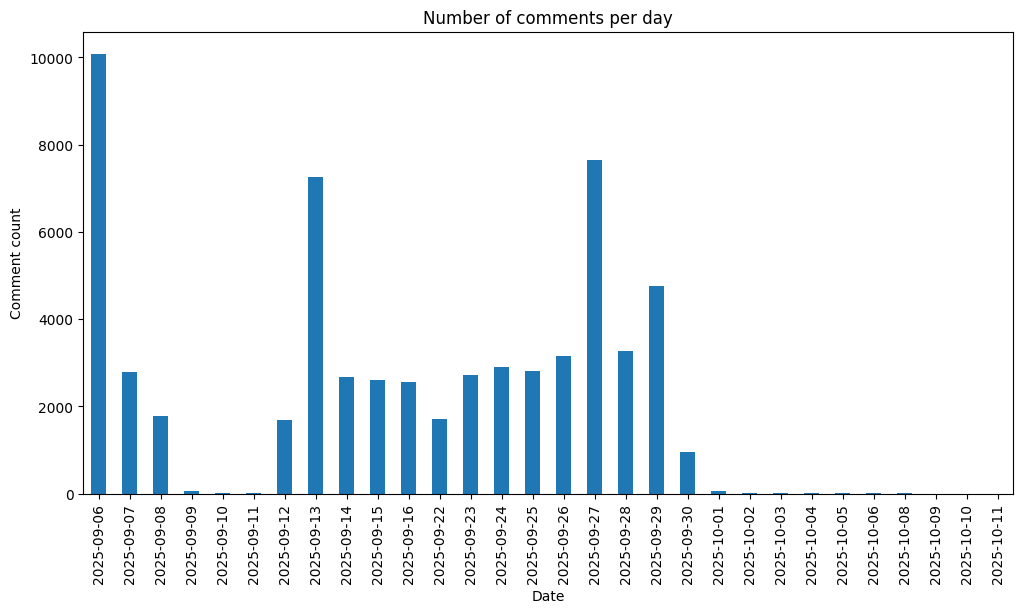

In [23]:
# Count comments per day
counts = afl_merge.groupby(afl_merge["created_datetime_utc"].dt.date).size()

plt.figure(figsize=(12,6))
counts.plot(kind="bar")
plt.title("Number of comments per day")
plt.xlabel("Date")
plt.ylabel("Comment count")
plt.xticks(rotation=90)
plt.show()

In [24]:
afl_merge.columns

Index(['id', 'link_id', 'parent_id', 'submission_id', 'author', 'score',
       'created_utc', 'created_datetime_utc', 'body', 'season', 'round',
       'date_utc', 'venue', 'home_team', 'away_team', 'home_goals',
       'home_behinds', 'home_score', 'away_goals', 'away_behinds',
       'away_score', 'winner_team', 'margin', 'is_final', 'is_grand_final',
       'game_id'],
      dtype='object')

In [25]:
afl_merge.winner_team

0               Geelong
1               Geelong
2               Geelong
3               Geelong
4               Geelong
              ...      
61591    Brisbane Lions
61592    Brisbane Lions
61593    Brisbane Lions
61594    Brisbane Lions
61595    Brisbane Lions
Name: winner_team, Length: 61596, dtype: object

In [26]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ============================================
# SENTIMENT ANALYSIS FUNCTIONS
# ============================================

def get_sentiment(text):
    """Calculate sentiment polarity and subjectivity using TextBlob"""
    if pd.isna(text) or text == '':
        return np.nan, np.nan
    try:
        blob = TextBlob(str(text))
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    except:
        return np.nan, np.nan

def categorize_sentiment(polarity):
    """Categorize polarity into positive/neutral/negative"""
    if pd.isna(polarity):
        return 'Unknown'
    elif polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

def analyze_sentiment(df):
    """Add sentiment analysis columns to dataframe"""
    print("🔍 Analyzing sentiment...")
    
    # Calculate sentiment
    df[['polarity', 'subjectivity']] = df['body'].apply(
        lambda x: pd.Series(get_sentiment(x))
    )
    
    # Categorize
    df['sentiment'] = df['polarity'].apply(categorize_sentiment)
    
    # Calculate word count
    df['word_count'] = df['body'].astype(str).apply(lambda x: len(x.split()))
    
    print(f"✅ Sentiment analysis complete!")
    return df


# ============================================
# ANALYSIS FUNCTIONS
# ============================================

def overall_stats(df):
    """Print overall sentiment statistics"""
    print("\n" + "="*60)
    print("📊 OVERALL SENTIMENT STATISTICS")
    print("="*60)
    
    total = len(df)
    print(f"\nTotal Comments: {total:,}")
    print(f"Date Range: {df['date_utc'].min()} to {df['date_utc'].max()}")
    
    # Sentiment distribution
    print("\n--- Sentiment Distribution ---")
    sent_counts = df['sentiment'].value_counts()
    for sent, count in sent_counts.items():
        pct = (count/total)*100
        print(f"{sent:12s}: {count:6,} ({pct:5.1f}%)")
    
    # Polarity stats
    print(f"\n--- Polarity Statistics ---")
    print(f"Mean Polarity: {df['polarity'].mean():.3f}")
    print(f"Median Polarity: {df['polarity'].median():.3f}")
    print(f"Std Dev: {df['polarity'].std():.3f}")


def team_sentiment(df):
    """Analyze sentiment by team"""
    print("\n" + "="*60)
    print("🏆 TEAM SENTIMENT ANALYSIS")
    print("="*60)
    
    # Home team sentiment
    home_sent = df.groupby('home_team').agg({
        'polarity': 'mean',
        'id': 'count'
    }).rename(columns={'id': 'comment_count'}).sort_values('polarity', ascending=False)
    
    print("\n--- Top 10 Teams by Average Sentiment (Home Games) ---")
    print(home_sent.head(10).to_string())
    
    # Away team sentiment
    away_sent = df.groupby('away_team').agg({
        'polarity': 'mean',
        'id': 'count'
    }).rename(columns={'id': 'comment_count'}).sort_values('polarity', ascending=False)
    
    print("\n--- Top 10 Teams by Average Sentiment (Away Games) ---")
    print(away_sent.head(10).to_string())
    
    return home_sent, away_sent


def winning_vs_losing_sentiment(df):
    """Compare sentiment for winning vs losing teams"""
    print("\n" + "="*60)
    print("🎯 WINNING vs LOSING TEAM SENTIMENT")
    print("="*60)
    
    # Create columns for whether comment is about winning team
    df['is_winner_home'] = df['home_team'] == df['winner_team']
    
    # Analyze home team comments
    home_win = df[df['is_winner_home'] == True]['polarity'].mean()
    home_lose = df[df['is_winner_home'] == False]['polarity'].mean()
    
    print(f"\nHome Team Comments:")
    print(f"  When Winning: {home_win:.3f}")
    print(f"  When Losing:  {home_lose:.3f}")
    print(f"  Difference:   {home_win - home_lose:.3f}")


def margin_analysis(df):
    """Analyze sentiment based on victory margin"""
    print("\n" + "="*60)
    print("📈 MARGIN OF VICTORY ANALYSIS")
    print("="*60)
    
    # Create margin categories
    df['margin_cat'] = pd.cut(df['margin'].abs(), 
                              bins=[0, 10, 30, 60, 200],
                              labels=['Close (<10)', 'Moderate (10-30)', 
                                     'Large (30-60)', 'Blowout (>60)'])
    
    margin_sent = df.groupby('margin_cat').agg({
        'polarity': ['mean', 'std'],
        'id': 'count'
    })
    
    print("\n--- Sentiment by Victory Margin ---")
    print(margin_sent.to_string())


def finals_analysis(df):
    """Compare finals vs regular season sentiment"""
    print("\n" + "="*60)
    print("🏅 FINALS vs REGULAR SEASON")
    print("="*60)
    
    finals_sent = df[df['is_final'] == True]['polarity'].mean()
    regular_sent = df[df['is_final'] == False]['polarity'].mean()
    
    print(f"\nFinals Games:        {finals_sent:.3f}")
    print(f"Regular Season:      {regular_sent:.3f}")
    print(f"Difference:          {finals_sent - regular_sent:.3f}")
    
    if df['is_grand_final'].sum() > 0:
        grand_final_sent = df[df['is_grand_final'] == True]['polarity'].mean()
        print(f"\nGrand Final:         {grand_final_sent:.3f}")


def temporal_analysis(df):
    """Analyze sentiment trends over time"""
    print("\n" + "="*60)
    print("📅 TEMPORAL TRENDS")
    print("="*60)
    
    # By round
    round_sent = df.groupby('round').agg({
        'polarity': 'mean',
        'id': 'count'
    }).rename(columns={'id': 'comments'})
    
    print("\n--- Sentiment by Round ---")
    print(round_sent.to_string())


def controversial_comments(df, top_n=10):
    """Find most controversial (high score, negative sentiment) comments"""
    print("\n" + "="*60)
    print("🔥 MOST CONTROVERSIAL COMMENTS")
    print("="*60)
    
    # High engagement + negative sentiment
    controversial = df[
        (df['score'] > df['score'].quantile(0.75)) & 
        (df['polarity'] < -0.3)
    ].sort_values('score', ascending=False).head(top_n)
    
    print(f"\n(High Score + Negative Sentiment)")
    for idx, row in controversial.iterrows():
        print(f"\nScore: {row['score']} | Polarity: {row['polarity']:.2f} | {row['home_team']} vs {row['away_team']}")
        print(f"Comment: {row['body'][:150]}...")


def most_positive_negative(df, n=5):
    """Show most positive and negative comments"""
    print("\n" + "="*60)
    print("😊 MOST POSITIVE COMMENTS")
    print("="*60)
    
    positive = df.nlargest(n, 'polarity')
    for idx, row in positive.iterrows():
        print(f"\nPolarity: {row['polarity']:.3f} | {row['home_team']} vs {row['away_team']}")
        print(f"{row['body'][:200]}")
    
    print("\n" + "="*60)
    print("😠 MOST NEGATIVE COMMENTS")
    print("="*60)
    
    negative = df.nsmallest(n, 'polarity')
    for idx, row in negative.iterrows():
        print(f"\nPolarity: {row['polarity']:.3f} | {row['home_team']} vs {row['away_team']}")
        print(f"{row['body'][:200]}")


# ============================================
# VISUALIZATION FUNCTIONS
# ============================================

def plot_sentiment_distribution(df):
    """Plot sentiment distribution"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Sentiment categories
    df['sentiment'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'gray', 'red'])
    axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Sentiment')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=0)
    
    # Polarity histogram
    axes[1].hist(df['polarity'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(df['polarity'].mean(), color='red', linestyle='--', label='Mean')
    axes[1].set_title('Polarity Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Polarity Score')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


def plot_team_sentiment(df):
    """Plot sentiment by team"""
    team_sent = df.groupby('home_team')['polarity'].mean().sort_values(ascending=False)
    
    plt.figure(figsize=(12, 8))
    team_sent.plot(kind='barh', color='steelblue')
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    plt.title('Average Sentiment by Team (Home Games)', fontsize=14, fontweight='bold')
    plt.xlabel('Average Polarity')
    plt.ylabel('Team')
    plt.tight_layout()
    plt.show()


def plot_margin_sentiment(df):
    """Plot sentiment vs margin"""
    plt.figure(figsize=(12, 6))
    
    # Scatter plot
    plt.scatter(df['margin'], df['polarity'], alpha=0.3, s=10)
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.axvline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel('Victory Margin', fontsize=12)
    plt.ylabel('Sentiment Polarity', fontsize=12)
    plt.title('Sentiment vs Victory Margin', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_temporal_trends(df):
    """Plot sentiment trends over rounds"""
    round_sent = df.groupby('round')['polarity'].mean()
    
    plt.figure(figsize=(14, 6))
    round_sent.plot(marker='o', linewidth=2, markersize=8)
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel('Round', fontsize=12)
    plt.ylabel('Average Sentiment', fontsize=12)
    plt.title('Sentiment Trend Across Season', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================
# MAIN ANALYSIS PIPELINE
# ============================================

def run_full_analysis(df):
    """Run complete sentiment analysis pipeline"""
    
    print("\n" + "="*60)
    print("🏈 AFL REDDIT SENTIMENT ANALYSIS")
    print("="*60)
    
    # Run sentiment analysis
    df = analyze_sentiment(df)
    
    # Run all analyses
    overall_stats(df)
    team_sentiment(df)
    winning_vs_losing_sentiment(df)
    margin_analysis(df)
    finals_analysis(df)
    temporal_analysis(df)
    most_positive_negative(df)
    controversial_comments(df)
    
    # Create visualizations
    print("\n\n📊 Generating visualizations...")
    plot_sentiment_distribution(df)
    plot_team_sentiment(df)
    plot_margin_sentiment(df)
    plot_temporal_trends(df)
    
    return df


# ============================================
# USAGE
# ============================================

# Run the analysis:
# df_analyzed = run_full_analysis(afl_merge)

# Or run individual analyses:
# df_analyzed = analyze_sentiment(afl_merge)
# overall_stats(df_analyzed)
# team_sentiment(df_analyzed)
# plot_sentiment_distribution(df_analyzed)

ModuleNotFoundError: No module named 'textblob'